In [ ]:
%load_ext watermark
%load_ext tensorboard

In [4]:
#loads required packages

%matplotlib inline
%config InlineBackend.figure_format = 'retina'


import ipywidgets as w
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas_datareader import data as pdr
import warnings
import pyfolio as pf
import empyrical as ep
from yahoofinancials import YahooFinancials as yf
from datetime import datetime
from dateutil.relativedelta import relativedelta
import tensorflow as tf
from sklearn.metrics import mean_squared_error
from math import sqrt

In [43]:
def date_from_widget():
    start_date = str(start_date_widget.value)
    end_date = str(end_date_widget.value)
    return start_date, end_date

In [44]:
tickers = ['FB','AAPL','TSLA','BP']

yahoo_financials = yf(tickers)
start_date_widget = w.DatePicker(description='Start Date')
end_date_widget = w.DatePicker(description='End Date')
display(start_date_widget, end_date_widget)

DatePicker(value=None, description='Start Date')

DatePicker(value=None, description='End Date')

In [45]:
date_from_widget()

('2020-04-01', '2020-04-07')

In [50]:
start_date,end_date = date_from_widget()
print(start_date,end_date)

2020-04-01 2020-04-07


In [53]:
data = yahoo_financials.get_historical_price_data(start_date,end_date,'daily')

prices_df = pd.DataFrame({
    asset: {x['formatted_date']: x['adjclose'] for x in data[asset]['prices']} for asset in tickers
})

prices_df.index.name="formatted_date"
prices_df.index = pd.to_datetime(prices_df.index)
prices_df.head()

,FB,AAPL,TSLA,BP
formatted_date,,,,
2020-04-01,159.600006,240.910004,481.559998,24.370001
2020-04-02,158.190002,244.929993,454.470001,26.030001
2020-04-03,154.179993,241.410004,480.010010,24.719999
2020-04-06,165.550003,262.470001,516.239990,25.049999


Text(0.5, 0, 'Date')

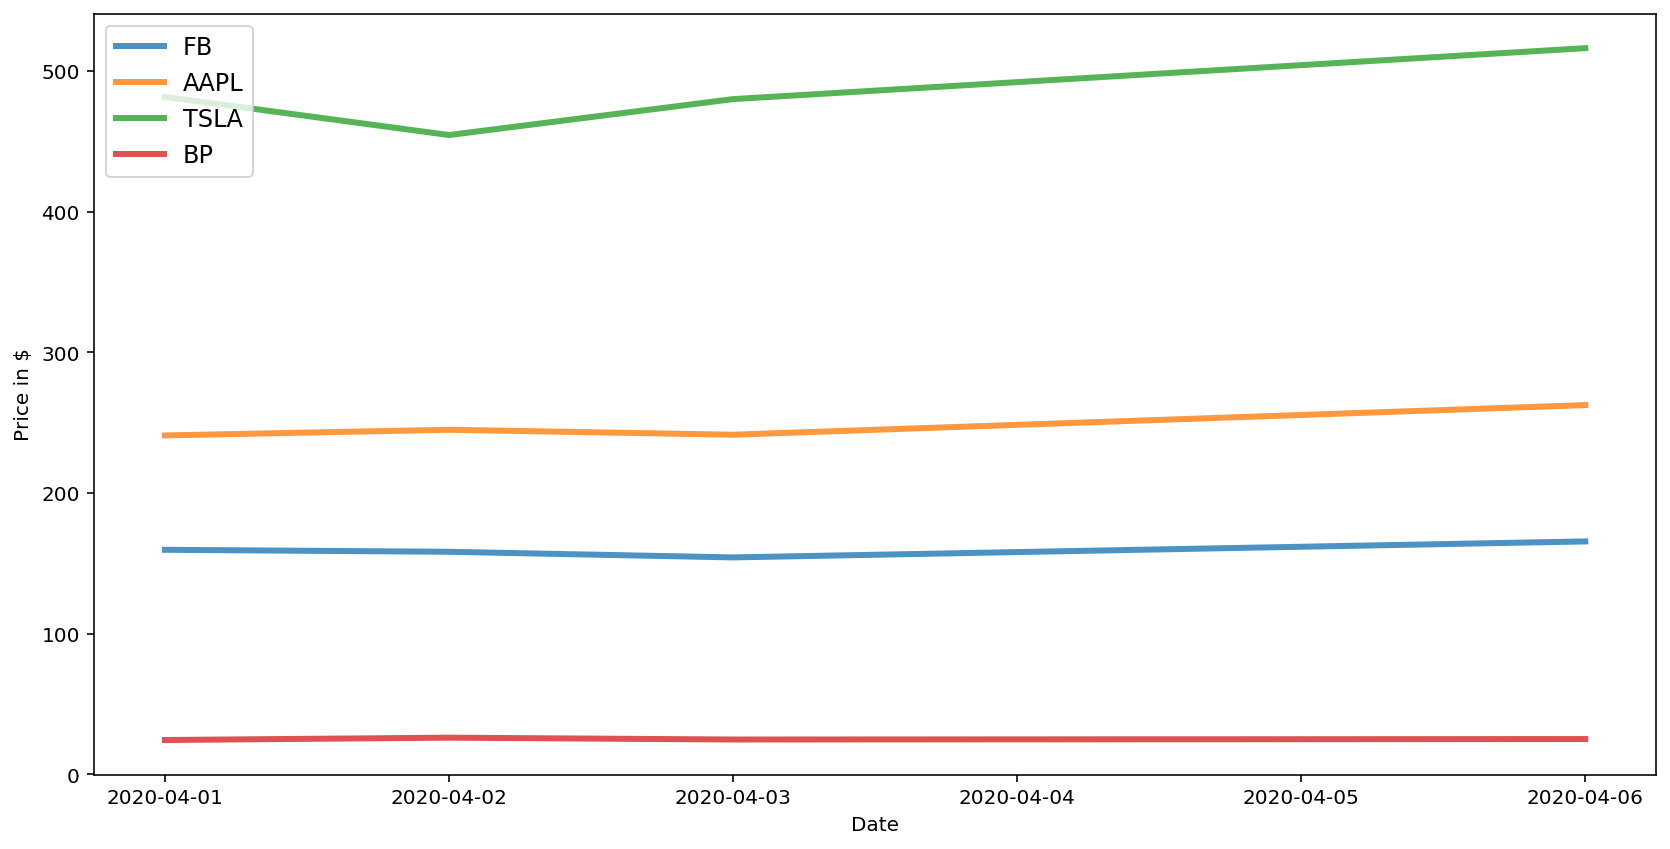

In [54]:
plt.figure(figsize=(14,7))
for c in prices_df.columns.values:
    plt.plot(prices_df.index,prices_df[c], lw=3, alpha=0.8,label=c)
plt.legend(loc='upper left', fontsize=12)
plt.ylabel('Price in $')
plt.xlabel('Date')

In [ ]:
returns = prices_df.pct_change()

plt.figure(figsize=(14,7))
for c in returns.columns.values:
    plt.plot(returns.index, returns[c], lw=3, alpha=0.8, label=c)
plt.legend(loc='upper right',fontsize=12)
plt.ylabel('Daily Returns')

In [ ]:
# https://towardsdatascience.com/efficient-frontier-portfolio-optimisation-in-python-e7844051e7f
def portfolio_annualised_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns*weights ) *252
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    return std, returns
  
def random_portfolios(num_portfolios, mean_returns, cov_matrix, risk_free_rate):
    results = np.zeros((3,num_portfolios))
    weights_record = []
    for i in range(num_portfolios):
        weights = np.random.random(4)
        weights /= np.sum(weights)
        weights_record.append(weights)
        portfolio_std_dev, portfolio_return = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
        results[0,i] = portfolio_std_dev
        results[1,i] = portfolio_return
        results[2,i] = (portfolio_return - risk_free_rate) / portfolio_std_dev
    return results, weights_record

In [ ]:
returns = prices_df.pct_change()
mean_returns = returns.mean()
cov_matrix = returns.cov()
num_portfolios = 25000
risk_free_rate = 0.0178

In [ ]:
def display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate):
    results, weights = random_portfolios(num_portfolios,mean_returns, cov_matrix, risk_free_rate)
    
    max_sharpe_idx = np.argmax(results[2])
    sdp, rp = results[0,max_sharpe_idx], results[1,max_sharpe_idx]
    max_sharpe_allocation = pd.DataFrame(weights[max_sharpe_idx],index=prices_df.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]

    max_sharpe_allocation.allocation
    max_sharpe_allocation = max_sharpe_allocation.T
    min_vol_idx = np.argmin(results[0])
    sdp_min, rp_min = results[0,min_vol_idx], results[1,min_vol_idx]
    min_vol_allocation = pd.DataFrame(weights[min_vol_idx],index=prices_df.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    
    
    print ("-"*80)
    print ("Maximum Sharpe Ratio Portfolio Allocation\n")
    print ("Annualised Return:", round(rp,2))
    print ("Annualised Volatility:", round(sdp,2))
    print ("\n")
    print (max_sharpe_allocation)
    print ("-"*80)
    print ("Minimum Volatility Portfolio Allocation\n")
    print ("Annualised Return:", round(rp_min,2))
    print ("Annualised Volatility:", round(sdp_min,2))
    print ("\n")
    print (min_vol_allocation)
    print (prices_df)

    
    
    plt.figure(figsize=(10, 7))
    plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='YlGnBu', marker='o', s=10, alpha=0.3)
    plt.colorbar()
    plt.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
    plt.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')
    plt.title('Simulated Portfolio Optimization based on Efficient Frontier')
    plt.xlabel('annualised volatility')
    plt.ylabel('annualised returns')
    plt.legend(labelspacing=0.8)

In [ ]:
display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate)